<a href="https://colab.research.google.com/github/ziatdinovmax/atomai/blob/master/examples/notebooks/atomai_vae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Variational Autoencoders in AtomAI

Prepared by Maxim Ziatdinov (July 2020)

Email: maxim.ziatdinov@ai4microscopy.com

Here we demonstrate an application of classical and rotationally-invariant variational autoencoders (VAEs) available in AtomAI for mapping structural transformations from atomically resolved images of graphene.

Install AtomAI:

In [2]:
!pip install git+https://github.com/ziatdinovmax/atomai@dev --upgrade

  Cloning https://github.com/ziatdinovmax/atomai (to revision dev) to /tmp/pip-req-build-5a8tjsrb
  Running command git clone -q https://github.com/ziatdinovmax/atomai /tmp/pip-req-build-5a8tjsrb
  Running command git checkout -b dev --track origin/dev
  Switched to a new branch 'dev'
  Branch 'dev' set up to track remote branch 'dev' from 'origin'.
  Created wheel for atomai: filename=atomai-0.4.0-cp36-none-any.whl size=57263 sha256=a384e64a0e91b6262cd3722db2555c5aaaf96a4cc631cc522b9ba4ea83f452d2
  Stored in directory: /tmp/pip-ephem-wheel-cache-mevvt1zw/wheels/27/8b/5a/95da97fef348e6587c5a248eefd7a1d0d10adf7412a1e5b454
Successfully built atomai


In [1]:
#@title Download datasets
!gdown https://drive.google.com/uc?id=1-JZSRjIjNjkR0ZQ8ffRDAZ2FID53Yhon
!gdown https://drive.google.com/uc?id=1-84vLdGFsimD1jaTcGcMzNRCSvjId7-Y
!gdown https://drive.google.com/uc?id=1-Lowglj7fwEFaJoC9EBKDyfCIsMgOnyu

Downloading...
From: https://drive.google.com/uc?id=1-JZSRjIjNjkR0ZQ8ffRDAZ2FID53Yhon
To: /content/3DStack13-1-dec.npy
157MB [00:03, 49.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-84vLdGFsimD1jaTcGcMzNRCSvjId7-Y
To: /content/3DStack13-1-exp.npy
52.4MB [00:00, 144MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1-Lowglj7fwEFaJoC9EBKDyfCIsMgOnyu
To: /content/3DStack13-1-coord.npy
2.45MB [00:00, 164MB/s]


Import needed modules:

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import atomai as aoi

Load raw experimental data, the semantically-segmented output from a deep neural network, and the extracted atomic coordinates:

In [4]:
imgdata = np.load('3DStack13-1-exp.npy')
decoded_imgs = np.load('3DStack13-1-dec.npy')
lattice_coord = np.load('3DStack13-1-coord.npy', allow_pickle=True)[()]

Plot data for the selected frame of atom-resolved movie:

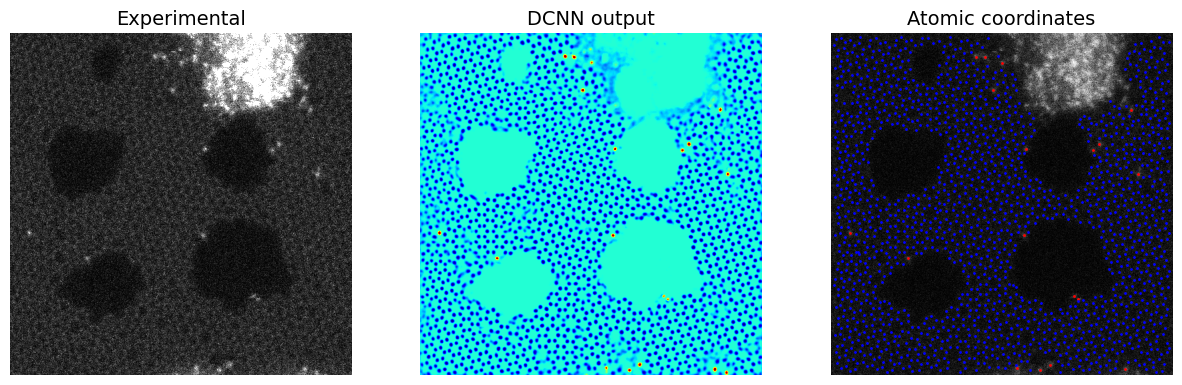

In [7]:
i = 25 # Choose movie frame

# Squeeze the channels in the predicted image (this is optional)
d_img = np.uint8(decoded_imgs[i]*255)
d_img = cv2.cvtColor(d_img, cv2.COLOR_BGR2GRAY)
# Get coordinates for C and Si atoms
lattice_coord_ = lattice_coord[i]
coord_Si = lattice_coord[i][lattice_coord[i][:,2]==1][:,0:2]
coord_C = lattice_coord[i][lattice_coord[i][:,2]==0][:,0:2]
# Plotting
fig = plt.figure(figsize = (15, 10), dpi = 100)
ax1 = fig.add_subplot(131)
ax1.imshow(imgdata[i,:,:,0], vmin=0, vmax=0.5, cmap='gray')
ax1.axis('off')
ax1.set_title('Experimental', fontsize=14)
ax2 = fig.add_subplot(132)
ax2.imshow(d_img, cmap='jet', Interpolation='Gaussian')
ax2.axis('off')
ax2.set_title('DCNN output', fontsize = 14)
ax3 = fig.add_subplot(133)
ax3.scatter(coord_Si[:,1], coord_Si[:,0], c='red', s=1)
ax3.scatter(coord_C[:,1], coord_C[:,0], c='blue', s=1)
ax3.imshow(imgdata[i,:,:,0], cmap = 'gray')
ax3.axis('off')
ax3.set_title('Atomic coordinates', fontsize = 14);

The VAEs will be trained on a stack of the subimages cropped around each detected atom. Here we create the training set:

In [8]:
window_size = 24
imstack, com_all, frames_all = aoi.utils.extract_subimages(
    np.sum(decoded_imgs[..., :-1], axis=-1), # sum all channels with atoms (Si and C)
    lattice_coord, window_size, 0)

Let's first train a conventional VAE:

In [9]:
vae = aoi.atomstat.VAE(imstack, training_cycles=200)
vae.run()

Epoch: 1/200, Training loss: 17.2308, Test loss: 11.8661
Epoch: 2/200, Training loss: 11.6330, Test loss: 11.5683
Epoch: 3/200, Training loss: 11.4354, Test loss: 11.3991
Epoch: 4/200, Training loss: 11.2742, Test loss: 11.2101
Epoch: 5/200, Training loss: 11.0410, Test loss: 10.8922
Epoch: 6/200, Training loss: 10.6714, Test loss: 10.5376
Epoch: 7/200, Training loss: 10.3561, Test loss: 10.3245
Epoch: 8/200, Training loss: 10.2209, Test loss: 10.2145
Epoch: 9/200, Training loss: 10.1435, Test loss: 10.1649
Epoch: 10/200, Training loss: 10.0957, Test loss: 10.0946
Epoch: 11/200, Training loss: 10.0408, Test loss: 10.0461
Epoch: 12/200, Training loss: 9.9970, Test loss: 10.0133
Epoch: 13/200, Training loss: 9.9549, Test loss: 9.9921
Epoch: 14/200, Training loss: 9.9290, Test loss: 9.9358
Epoch: 15/200, Training loss: 9.8934, Test loss: 9.9108
Epoch: 16/200, Training loss: 9.8766, Test loss: 9.8721
Epoch: 17/200, Training loss: 9.8454, Test loss: 9.8720
Epoch: 18/200, Training loss: 9.82

Visualize the learned manifold:

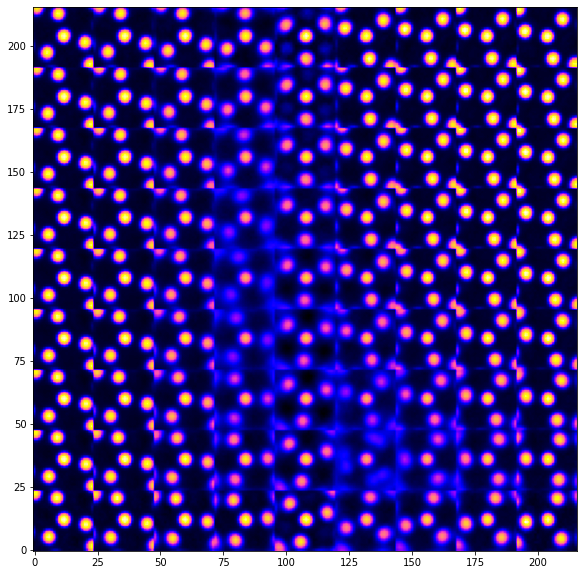

In [10]:
vae.manifold2d(cmap="gnuplot2")

Here, the descriptors on the left and right correspond to two graphene sublattices, while those in the middle encode lateral shifts, defects, and rotations in a convoluted fashion. 

Now let's train a rotationally-invariant VAE (rVAE):

In [11]:
rvae = aoi.atomstat.rVAE(imstack, training_cycles=200)
rvae.run()

Epoch: 1/200, Training loss: 31.2855, Test loss: 24.4279
Epoch: 2/200, Training loss: 24.3875, Test loss: 24.2701
Epoch: 3/200, Training loss: 24.2421, Test loss: 24.1352
Epoch: 4/200, Training loss: 24.0850, Test loss: 23.9511
Epoch: 5/200, Training loss: 23.9094, Test loss: 23.8095
Epoch: 6/200, Training loss: 23.7914, Test loss: 23.7107
Epoch: 7/200, Training loss: 23.6939, Test loss: 23.6231
Epoch: 8/200, Training loss: 23.6148, Test loss: 23.5496
Epoch: 9/200, Training loss: 23.5531, Test loss: 23.4999
Epoch: 10/200, Training loss: 23.4229, Test loss: 23.1267
Epoch: 11/200, Training loss: 22.3758, Test loss: 21.3515
Epoch: 12/200, Training loss: 20.2251, Test loss: 19.2176
Epoch: 13/200, Training loss: 18.6591, Test loss: 18.1744
Epoch: 14/200, Training loss: 17.7126, Test loss: 17.2947
Epoch: 15/200, Training loss: 16.8540, Test loss: 16.5153
Epoch: 16/200, Training loss: 16.1556, Test loss: 15.8585
Epoch: 17/200, Training loss: 15.6124, Test loss: 15.3295
Epoch: 18/200, Training

Visualize the learned manifold:

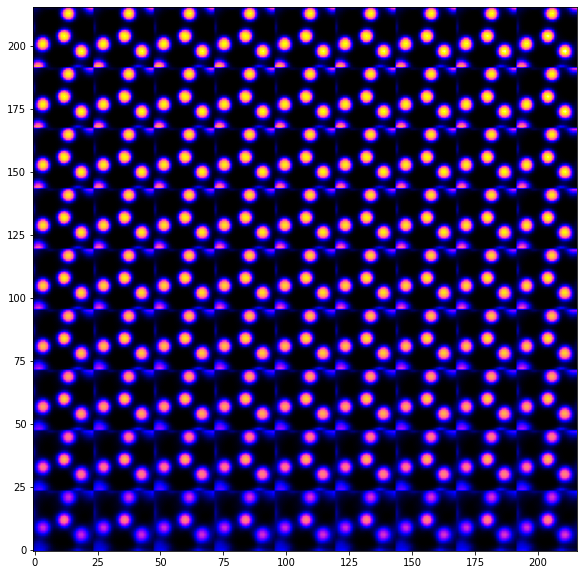

In [13]:
rvae.manifold2d(cmap="gnuplot2")

Since rotational variation is effectively removed from elementary descriptors, remaining variations within data can be described much more efficiently than with the regular VAE.

Now let's encode the entire image stack (our movie). Here the first latent variable is associated with rotation, the second and third ones are associated with translations in *x* and *y* directions, and the latent variables starting from the third one correspond to images content.

In [12]:
z_mean, z_sd = rvae.encode(imstack)
z1, z2, z3 = z_mean[:,0], z_mean[:, 1:3], z_mean[:, 3:]

Plot distributions of "structural" latent variables (angle and translations):

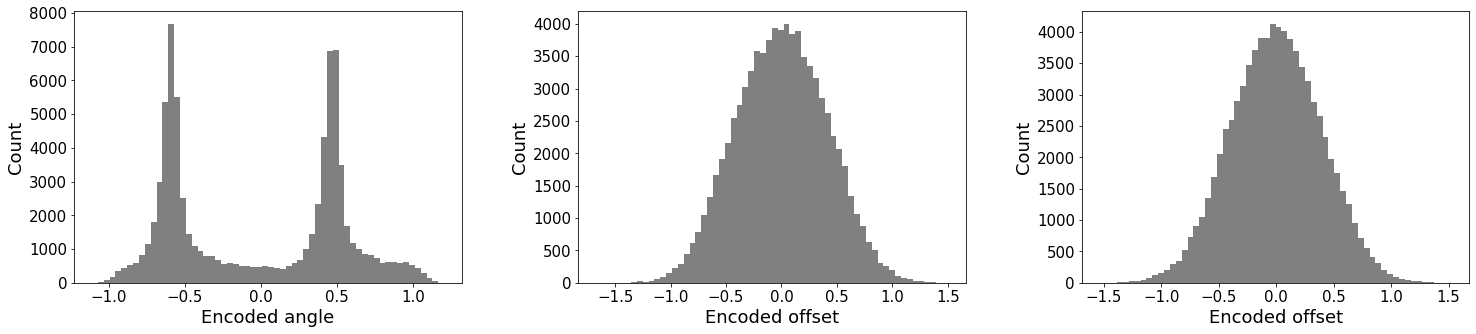

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(25, 5))
ax[0].hist(z1, bins=60, color='gray')
ax[1].hist(z2[:, 0], bins=60, color='gray')
ax[2].hist(z2[:, 1], bins=60, color='gray')
ax[0].set_xlabel("Encoded angle", fontsize=18)
ax[1].set_xlabel("Encoded offset", fontsize=18)
ax[2].set_xlabel("Encoded offset", fontsize=18)
for _ax in fig.axes:
    _ax.set_ylabel("Count", fontsize=18)
    _ax.tick_params(labelsize=15)
plt.subplots_adjust(wspace=0.3)

Finally we map the encoded values associated with the subimages (encoded angle and latent variables associated with images content) onto the original movie frames:

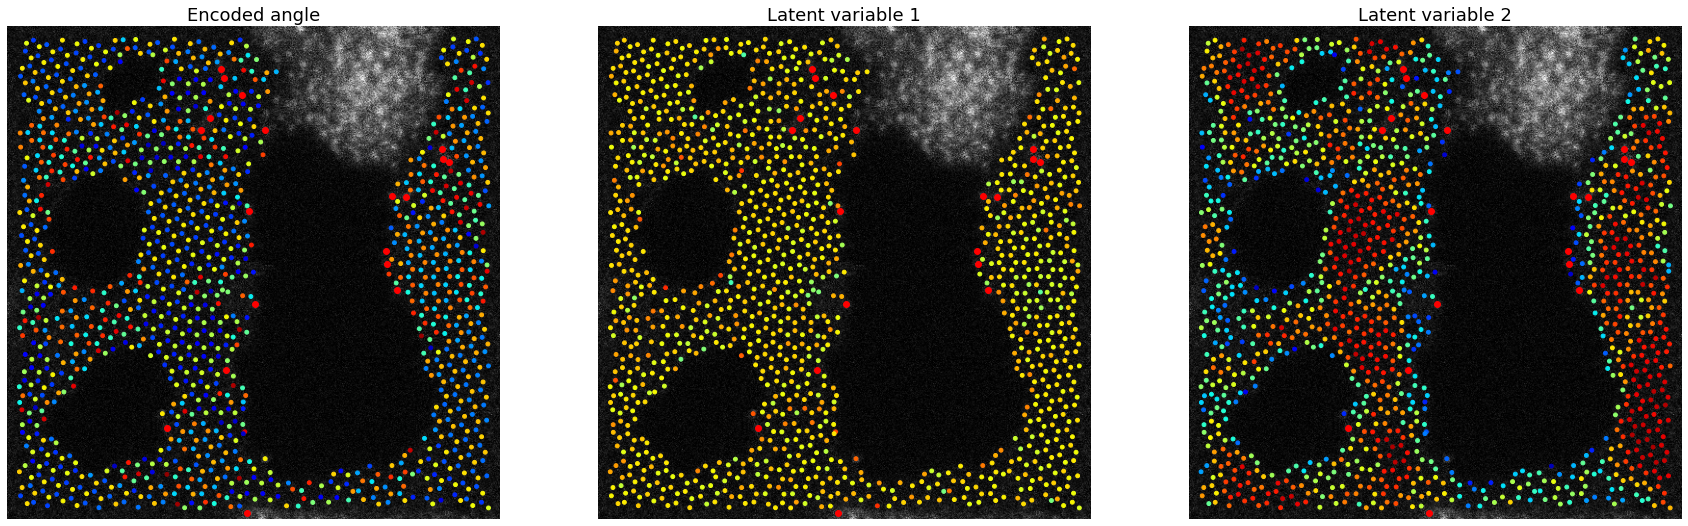

In [14]:
frame = 49 # select frame

com_i = com_all[frames_all == frame] # get coordinates for this frame
com_i_Si = lattice_coord[frame] # get Si coordinates for plotting
com_i_Si = com_i_Si[com_i_Si[:,-1]==1.]
z1_i = z1[frames_all == frame] # get latent variables (image) for this frame
z3_i = z3[frames_all == frame] # get latent variables (image) for this frame

col_min0 = z1.min()
col_max0 = z1.max()
col_min1 = z3[:, 0].min()
col_max1 = z3[:, 0].max()
col_min2 = z3[:, 1].min()
col_max2 = z3[:, 1].max()

fig, ax = plt.subplots(1, 3, figsize=(30, 10))
ax[0].imshow(imgdata[frame,...,0], cmap="gray")
ax[0].scatter(com_i[:, 1], com_i[:, 0], c=z1_i, s=15,
            cmap="jet", vmin=col_min0, vmax=col_max0)
ax[0].set_title("Encoded angle", fontsize=18)
ax[1].imshow(imgdata[frame,...,0], cmap="gray")
ax[1].scatter(com_i[:, 1], com_i[:, 0], c=z3_i[:, 0], s=15,
            cmap="jet", vmin=col_min1, vmax=col_max1)
ax[1].set_title("Latent variable 1", fontsize=18)
ax[2].imshow(imgdata[frame,...,0], cmap="gray")
ax[2].scatter(com_i[:, 1], com_i[:, 0], c=z3_i[:, 1], s=15,
              cmap="jet", vmin=col_min2, vmax=col_max2)
ax[2].set_title("Latent variable 2", fontsize=18)
for _ax in fig.axes:
    _ax.scatter(com_i_Si[:, 1], com_i_Si[:, 0], s=35, c='Red')
    _ax.axis(False)
plt.show()

Here, the color scale of each atomic unit is set according
to the value of the corresponding latent variable for angle (first image) and first two latent variable associated with images content (second and third images). The angle variable shows clear contrast for the two structurally unique sublattice positions in the graphene lattice, giving rise to the checkerboard-like pattern. Small angle boundaries and the rotation between graphene fragments are clearly visible. At the same time, the behavior of the second latent variable corresponding to the content of sub-images clearly shows that it adopts maximum value in the well-ordered regions and is reduced at the edges and in regions with high defect density, allowing for its interpretation as local crystallinity. 